# topic modeling pipeline

This notebook will walk you through:
1. data reterival from SQL database
2. Pre-processing data
3. Running topic modeling (different models)
4. post processing (including showing topics, topic-doc distribution, etc.)
5. Storing results into DB

# imports

In [1]:
from pre_processing import remove_html_tags, preprocess_data, prepare_corpus
from post_processing import topic_selection
from rpy2 import robjects #loading R inside Python
#importing functions to read pandas DF
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

import pandas as pd

import numpy as np

import os

#import R base library
base = importr('base')

mallet_path = 'mallet' #'mallet for mac-os

[nltk_data] Downloading package stopwords to /Users/das-
[nltk_data]     lab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/das-lab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/das-lab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/das-lab/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


loading stop words

In [8]:
#downloading github repo for down-sampling==> you only need this once!
# !git clone https://github.com/aminmarani/authorless-tms.git

Cloning into 'authorless-tms'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 36 (delta 3), reused 8 (delta 3), pack-reused 28
Receiving objects: 100% (36/36), 395.53 KiB | 4.82 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
stop_words = []

with open('freqPOS+Names.stop','r') as txtfile:
    for r in txtfile:
        stop_words.append(r.strip())
        if "'" in r:#add the term without "'"; e.g., haven't & havent
            stop_words.append(r.replace("'","").strip())

stop_words[10:15]

['duncan', 'fluffy', 'jack', 'jake', 'jim']

# Loading data from SQL database

First creating a connection

**In order to create a connection from anywhere in LU network you need to run the command below in terminal. Replace your username with amh418 in the command below.**

ssh -L 3306:127.0.0.1:3306 -N -f amh418@128.180.111.76   #it will ask for lehigh pass

on network (128.180.111.76)
outside the network (ssh.lehigh.edu)

**if you need to kill to SSH forwarding use the link below**

https://superuser.com/questions/87014/how-do-i-remove-an-ssh-forwarded-port


In [3]:
import mysql.connector

#connecting to DB
cnx = mysql.connector.connect(user='push', password='ElI)g!LDOBIwM)%*5o5{dbfz('
                              ,host='127.0.0.1',database='edml')

Retreiving all the posts

**We are exlcuding recoverwithmeda for now**

In [30]:
cursor = cnx.cursor() #making a cursor to execute a SQL command
# cursor.execute("select * from post") #execute a command
cursor.execute("select * from post where user_id != (select user_id from user where user_login='recoverwithmeda')") #execute a command
myresult = cursor.fetchall() #get all the results 
print('{0} posts were retreived'.format(len(myresult))) 

8341 posts were retreived


In [31]:
#loading user_id and user_name to convert id to user_name
cursor.execute("select * from user") #execute a command
users = cursor.fetchall() #get all the results 
users = {i[0]:i[1] for i in users}
myresult = [i[0:2] + tuple([users[i[2]]]) + i[3:] for i in myresult]

In [32]:
#concatenating the old dataset to the new one
myresult_ = [tuple(i[1:]) for i in pd.read_csv('./data/old_ed.csv',index_col=None).values]
myresult += myresult_
print('{0} posts were retreived'.format(len(myresult))) 

21338 posts were retreived


Language detection

keeping only English language posts/documents

In [ ]:
from langdetect import detect
from tqdm import tqdm


# myresult = [s for s in myresult if len(remove_html_tags(s[3])) > 3 and detect(remove_html_tags(s[3]))=='en']
t = []
#removing tags and detecting language afterward
for s in tqdm(myresult):
    try:#in some case language detection may fail (emojies only, one word docs, etc.) ==> We don't keep those
        if detect(remove_html_tags(s[3]))=='en':
            t.append(s)
    except:
        pass #do nothing

myresult = t[:]
print('after removing non-english posts,the size of the documents are: {0}'.format(len(myresult)))

 38%|██████████████                       | 8130/21338 [00:49<01:14, 177.31it/s]

# preprocessing the data

First, removing html tags

prepare the corupus

In [ ]:
#removing tags from texts
proc_texts = [remove_html_tags(i[3]) for i in myresult]
#pre_processing and tokenizing docs
pre_processed_docs,orig_docs = preprocess_data(proc_texts,extra_stopwords=stop_words)
#attaching (id,original_text,pre_processed_text,date,url) together
id_text = [(myresult[orig_docs[i][1]][0],orig_docs[i][0],pre_processed_docs[i],
            myresult[orig_docs[i][1]][4],myresult[orig_docs[i][1]][5],
            myresult[orig_docs[i][1]][2]) for i in range(len(orig_docs))]

# vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs) ==> we don't need prepare corpus as we are passing this to LDA and STM R and there they will do tokenization 

#creat a pandas DF with one column as text, one column as original text, one column as SQL post-id, etc.
text_df = pd.DataFrame(zip([i[0] for i in id_text],[' '.join(i[2]) for i in id_text],
                           [i[1] for i in id_text],[i[3] for i in id_text],[i[4] for i in id_text],
                          [i[5] for i in id_text]),
                       columns=['id','text','original_text','date','url','blog'])

In [ ]:
#removing duplicates only if necessary
print(len(text_df))
text_df = text_df.drop_duplicates(subset=['text'])
print(len(text_df))

Processing documens for Topicalizer

In [7]:
# text_df[['date','original_text','url']].rename(columns={'original_text':'entry','url':'Link'}).to_csv('./data/processed_ed.csv')

# Author down-sampling

down-sampling terms that are more specific to an author

In [ ]:
vocab = set()

for tx in list(text_df.text):
    tokens = tx.split()
    [vocab.add(t) for t in tokens]

with open('./data/temp_vocab_corpus.txt','w') as tfile:
    tfile.writelines([i+'\n' for i in list(vocab)])

print('size of dictionary is {0}'.format(len(vocab)))

In [ ]:
#storing corpus for down-sampling (we send the pre-processed docs)
text_df[['blog','text']].to_csv('./data/temp_documents_corpus.txt',index=True,sep='\t',
                                header=False,encoding="UTF-8")

In [ ]:
#running down-sampling ==> if the original file in repo pops error you need to make changes in the downsample_corpus.py as stated below
#line 68: term_means = np.mean(author_term_freqs, axis=0).ravel() 
#line 71: term_vars = np.var(author_term_freqs, axis=0, ddof=1).ravel()
#line 83: author_term_freqs = author_term_freqs.toarray()#added 2023,Nov
#line 88: author_freqs = author_term_freqs[:, term_id].ravel()#.getA1() #added 2023,Nov
!python3 ./authorless-tms/downsample_corpus.py --input ./data/temp_documents_corpus.txt --output ./data/temp_documents_corpus_new015.txt --vocab ./data/temp_vocab_corpus.txt --threshold 0.05

In [27]:
#updating text_df
new_df = pd.read_csv('./data/temp_documents_corpus_new005.txt',sep='\t',header=None,
                     names=['blog','text'])

#replacing down-sampled data with original data
for id,row in tqdm(new_df.iterrows()):
    text_df.at[id,'text'] = row['text']

#removing the ones that were deleted during down-sampling
text_df = text_df[text_df.index.isin(new_df.index)]

print('Number of documents after down-sampling: {0}'.format(len(text_df)))

7727it [00:00, 12904.21it/s]


Number of documents after down-sampling: 7727


# Running topic modeling (with or without evaluation)

In [8]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')

# utils.install_packages('stm',repos="https://cloud.r-project.org")

In [28]:
is_eval = True #not evaluating the model
lon,upn = 5,30 #lowwer and upper topic number for evaluation
#need to provide number of topics and other specification
model_spec = {'name':'LDA','K':21,'epochs':2000,'burnin_iteration':20,'after_iteration_burnin':50,
             'save_flag':True,'save_path':'LDA_test'}
# model_spec = {'name':'STM','K':90,'epochs':500,'prevalence':'','content':'','pre_trained_model': 'LDA',\
#                 'burnin_iteration':20,'LDA_epochs':50,'save_flag':True}

if model_spec['name'] == 'LDA':
    if is_eval:
        #loading LDA mallet evaluation score
        from lda_mallet import lda_score
        from gensim.corpora import Dictionary
        import pickle
        from pre_processing import prepare_corpus
        #creating data vocab
        dict = Dictionary([i.split() for i in list(text_df.text)])
        #saving it to pass it to score object
        with open ('./data/ED_vocab.obj','wb') as vfile:
            pickle.dump(dict,vfile)
        wiki_vocab_dict_path = './data/wiki_sampled5p_vocab.obj'
        with open ('./data/wiki_sampled5p_vocab.obj','rb') as vfile:
            wiki_vocab_dict = pickle.load(vfile)


        npmis = []
        for n_topics in range(lon,upn,1):
            #removing terms that are not in the Wiki Vocab
            #pre_processing and tokenizing docs
            # pre_processed_docs,_ = preprocess_data(list(text_df.text),extra_stopwords=\
            #                                                set(dict.values()).difference(set(wiki_vocab_dict.values()))\
            #                                        .union(['denying']))
            pre_processed_docs,_ = preprocess_data(list(text_df.text))
            #preparing corpus
            vocab_dict,doc_term_mat = prepare_corpus(pre_processed_docs)
            #temp save of vocab file
            with open ('./data/ED_vocab.tmp','wb') as vfile:
                pickle.dump(vocab_dict,vfile)
            
            scorer = lda_score(num_topics=n_topics,alpha=10,optimize_interval=10,iterations=2000,wiki_path='./data/wiki_sampled_5p.txt',
                      db_path = './data/wiki_full/',vocab_dict_path = './data/ED_vocab.tmp', 
                      wiki_vocab_dict_path=wiki_vocab_dict_path,npmi_skip_threshold=0.30)
            
            scorer.fit(doc_term_mat)#fitting an LDA Mallet
            npmis.append([n_topics,scorer.score()])
    else: 
        #removing previously created mallet_file
        try:
            os.remove('MalletInstance_ {0}'.format(model_spec['save_path'])) 
            os.remove('MalletState_ {0} .gz'.format(model_spec['save_path']))
            os.remove('MalletSpec_ {0}'.format(model_spec['save_path']))
        except:#in case we don't have any files
            pass
        robjects.r.source('LDA_R.R')
        copy_text_df = text_df.copy()
        ans = robjects.r.findTopics(docs = copy_text_df,n_topics = model_spec['K'],epochs = model_spec['epochs'],
                                    burnin_iteration = model_spec['burnin_iteration'],
                                    after_iteration_burnin =  model_spec['after_iteration_burnin'],
                                    save_flag=model_spec['save_flag'],save_path = model_spec['save_path'])
        top_terms = np.asarray(ans[1])
        topic_doc_dist = np.asarray(ans[0][0]).T
        term_probab = ans[0][1]
        topic_vocab = ans[0][2]
        
        
elif model_spec['name'] == 'STM':
    if is_eval:
        pass
    else: 
        robjects.r.source('stm.R')
        ans = robjects.r.run_stm(docs = text_df,topic_n=model_spec['K'],max_itr=model_spec['epochs'],
                                 prevalence=model_spec['prevalence'],content=model_spec['content'],
                                 model_type = model_spec['pre_trained_model'],
                                 nits = model_spec['LDA_epochs'],burnin = model_spec['burnin_iteration'],
                                 save_flag = True)
        top_terms = np.asarray(ans[1]).reshape(model_spec['K'],50,order='F')
        topic_doc_dist = 0.00

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.37408
<20> LL/token: -7.96924
<30> LL/token: -7.8596
<40> LL/token: -7.80207

0	2	food eat meal water free good breakfast chocolate protein cup vegan add day lunch meals minutes bowl dinner top enjoy 
1	2	day love today time good hope happy friends post week home days morning fun share friend weekend tomorrow night big 
2	2	time back year work years things week school family past home life end lot long ago times big hard taking 
3	2	feel eating weight recovery time eat disorder hard bad good back feeling lot felt ed brain thing things talk feels 
4	2	body life people feel food things health eating healthy love live care important change world person mental mind worth eat 

<50> LL/token: -7.77119
<60> LL/token: -7.75142
<70> LL/token: -7.73818
<80> LL/token: -7.72242
<90> LL/token: -7.71581

0	2	food eat meal water breakfast chocolate free protein cup good vegan add mi

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.39444
<20> LL/token: -8.01938
<30> LL/token: -7.90197
<40> LL/token: -7.84927

0	1.66667	people body feel health person weight life things important care mental real change part recovery post deserve years hard lot 
1	1.66667	life love time things day hope happy feel live feeling world give good living remember back friends show share past 
2	1.66667	day good today week full days long food fun weekend pretty hope happy post free time calories find rest healthy 
3	1.66667	eating food eat feel body disorder time good weight bad recovery lot brain ed thoughts hard control feeling back days 
4	1.66667	water chocolate breakfast protein cup free vegan add meal minutes bowl food top butter eat cream sweet dinner completely sugar 
5	1.66667	time back home year family work today school things bit friends week felt stay wanted friend hard morning end hours 

<50> LL/token: -7.81

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 7 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.54064
<20> LL/token: -8.0902
<30> LL/token: -7.97053
<40> LL/token: -7.90797

0	1.42857	food eat meal protein good meals water vegan breakfast lunch chocolate bowl dinner cream add sweet white cake cheese bread 
1	1.42857	feel things life people feeling world years hard talk lot time felt feels person remember part thoughts support thought past 
2	1.42857	time back day today home days year work school stay family week sleep good bed feeling bit friends weeks room 
3	1.42857	love time life friends day good post hope live happy give share week put start check real perfect amazing friend 
4	1.42857	body eating food weight eat feel health healthy day life bad diet mental foods worth control matter exercise important people 
5	1.42857	day today free week morning set weekend love happy good cup completely cool hope fun night place top minutes fall 
6	1.42857	eating recovery 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.6151
<20> LL/token: -8.14042
<30> LL/token: -7.98685
<40> LL/token: -7.92024

0	1.25	time year love back school years story start wanted work share end friends thought ago long friend follow find months 
1	1.25	eating recovery time disorder feel back felt hard ed things brain work bad past lot talk times head started feeling 
2	1.25	feel life time good back things start stop long put fucking face shit literally pretty people hope small hard question 
3	1.25	day week love time today home hope happy friends weekend family fun post days good morning big super taking full 
4	1.25	body weight life health healthy feel food change love diet eating mind worth thoughts day exercise important control gain bodies 
5	1.25	food eat day good today eating meals morning night meal foods days full lunch ate hours bed sleep breakfast calories 
6	1.25	people feel life things care person 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.61784
<20> LL/token: -8.12893
<30> LL/token: -7.99737
<40> LL/token: -7.92844

0	1.11111	people love life hope share post find world person years story give friends social live year family things show start 
1	1.11111	day food good meal full eat lunch meals love dinner week based night super coffee yesterday great find fun easy 
2	1.11111	feel things hard time felt talk times lot years back told feeling thoughts past stuff feelings feels brain bad parents 
3	1.11111	time day today work back home taking stay bed sleep put care long feel nice hours days face feeling friends 
4	1.11111	water chocolate protein cup vegan add free bowl minutes butter cream breakfast top completely sugar cake milk cheese set sweet 
5	1.11111	time good feel week back thing day pretty start wanted thought point lot days work bit reason leave small stop 
6	1.11111	day today time week year back 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.6437
<20> LL/token: -8.1858
<30> LL/token: -8.03912
<40> LL/token: -7.96177

0	1	water chocolate protein cup add bowl minutes butter vegan cream breakfast top sugar cake white completely set milk cheese hot 
1	1	people recovery life eating feel disorder years mental person part ed talk work things wrong struggling proud feeling journey experience 
2	1	day today good morning home night time friends happy days work yesterday weekend bed hope lunch rest fun pm sleep 
3	1	body weight feel health healthy diet mind change exercise gain bodies fat physical lose life size skin bad fit important 
4	1	food eat eating day feel good foods days time calories stop lot long bad meals binge ate hungry ed number 
5	1	love life people things world feel live real happy hope care living share positive day heart beautiful remember show give 
6	1	things time hard feel back felt told lot t

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.71369
<20> LL/token: -8.22433
<30> LL/token: -8.06128
<40> LL/token: -7.98616

0	0.90909	post good day happy pretty back friend follow love check real hair lol give friends time blog posts stay story 
1	0.90909	time back things years started lot thought life felt told part week wanted start therapy year bit school long stuff 
2	0.90909	water cup minutes free top completely set cool chocolate morning place sugar breakfast add milk cheese bread vegan hot sit 
3	0.90909	feel things people hard good feeling life person love mind feels talk relationship feelings care kind thoughts words deserve positive 
4	0.90909	life love time year live hope find change world years living remember day share book read grateful reading content things 
5	0.90909	day today home time days week good back morning work night weekend feeling happy friends school run taking yesterday bed 
6	0.909

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.70649
<20> LL/token: -8.23073
<30> LL/token: -8.06577
<40> LL/token: -7.99098

0	0.83333	feel things hard thoughts time felt good feels lot feeling part brain feelings thought work kind started wanted relationship learning 
1	0.83333	body life day change feel things health start skin mental mind years love beautiful hair ways person happy care remember 
2	0.83333	chocolate protein cup free vegan add water butter minutes sugar cake set top completely milk enjoy cool bowl breakfast peanut 
3	0.83333	life people things feel world live love care real change deserve power person human matter important remember living choose social 
4	0.83333	feel good day time days bad food give feeling thing eat long lot energy stop put big times tired great 
5	0.83333	talk time years question face story friend find told family lot questions sense care read people knew pain answer things

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.75371
<20> LL/token: -8.28937
<30> LL/token: -8.11272
<40> LL/token: -8.03206

0	0.76923	time feel talk good hard things face week stuff thing lot therapy head work nice bit back kind person sit 
1	0.76923	people family friends social post pretty care find hope content check lot book media read blog link wear holiday friend 
2	0.76923	feel feeling things time hard brain felt feelings wrong good bad anxiety feels experience started parents lot anxious understand thoughts 
3	0.76923	chocolate protein cup free butter vegan add minutes completely sugar water bowl milk place breakfast set top cool peanut banana 
4	0.76923	day today time home good week work happy taking days back friends hope weekend morning life rest feeling tomorrow school 
5	0.76923	people life feel recovery real love ed fucking world deserve person matter care hard human hate things give live skin 
6	0

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.77652
<20> LL/token: -8.28799
<30> LL/token: -8.13304
<40> LL/token: -8.05899

0	0.71429	people life lot world mental social family real health part important experience thing care years hope things feeling remember feel 
1	0.71429	chocolate protein vegan bowl butter cup cream water add milk sweet meal bread free breakfast peanut veggies banana lunch rice 
2	0.71429	time year back school feeling years feel moment work month job feels big home world sad times things working life 
3	0.71429	people eating recovery disorder ed care person support disorders find part proud post helpful struggling recover work life give blog 
4	0.71429	food eat eating foods feel day good healthy body meals calories binge fucking ate bad hungry diet meal shit lot 
5	0.71429	love day hope good free friends weekend time give share rest friend story book year show holiday happy christmas tag 


Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.88974
<20> LL/token: -8.3543
<30> LL/token: -8.16509
<40> LL/token: -8.08192

0	0.66667	body food weight eating eat healthy health feel diet foods calories fat bad gain day size lose hunger loss culture 
1	0.66667	time feel hard feeling things feels work stop care working stay head find kind long taking put good helps number 
2	0.66667	people read book family comment big girl hope amazing back story years place thing time wear group good means call 
3	0.66667	back time home tomorrow friends long run pretty wanted minutes bit running face today left week money nice late friend 
4	0.66667	feel part things thoughts talk brain relationship told lot wrong parents feelings person people words sense therapy fear experience understand 
5	0.66667	eating recovery disorder people ed shit mental post disorders health follow care blog fuck fucking friend recover give tumblr journ

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 16 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.84553
<20> LL/token: -8.32068
<30> LL/token: -8.15692
<40> LL/token: -8.07642

0	0.625	post lot feel thing hair read wear pretty real find hope content people remember link time good give fact positive 
1	0.625	people years life year world parents support part things learn past relationship person talk thought knew learning lot experience start 
2	0.625	good time free hope full family love great easy happy christmas super amazing long enjoy weekend fun pretty day lots 
3	0.625	day white meal coffee home summer cold super rice lunch drink today favorite dinner kitchen water black perfect easy full 
4	0.625	eating food eat disorder feel foods bad lot calories binge control hungry disorders health ate meals mental body healthy stop 
5	0.625	day today days morning home good week time night bed tomorrow weekend pm yesterday taking feeling back happy run work 
6	0.625	peop

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 17 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.83853
<20> LL/token: -8.35212
<30> LL/token: -8.17171
<40> LL/token: -8.08898

0	0.58824	food eat eating day good foods meals ate calories feel hungry lunch bad full lot today hunger healthy days eaten 
1	0.58824	body weight healthy feel diet health fat gain exercise size loss culture matter bad image thing skin worth mind working 
2	0.58824	feel felt time hard good bit back week things feeling work started therapy stuff told bad talk wanted remember couple 
3	0.58824	day time today good hope happy run long book yesterday week running half taking read birthday grateful friends back love 
4	0.58824	time back thing sit minutes good start side put white bit room apple coming left safe happened small times nice 
5	0.58824	meal protein water butter bowl add breakfast milk cup peanut dinner veggies banana lunch rice week half easy hot almond 
6	0.58824	people things feel 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.89352
<20> LL/token: -8.36377
<30> LL/token: -8.19857
<40> LL/token: -8.12437

0	0.55556	body love life day feel change happy good live week give hope energy beautiful deserve exercise real bodies post goals 
1	0.55556	day today time home week morning work back days bed sleep good rest taking friends night weekend school tomorrow early 
2	0.55556	back hard days time long things start work thoughts mind thought break remember talking feeling stop proud end started easy 
3	0.55556	recovery people ed feel care fucking shit back sick hate bad disorder fuck question answer literally post gonna hard hurt 
4	0.55556	eat food eating feel day lot control foods bad binge meals time fear ate days good meal normal full brain 
5	0.55556	feel things time talk felt told therapy hard brain bit started stuff part week feels back wanted happened head asked 
6	0.55556	year time thing 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 19 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.83158
<20> LL/token: -8.36456
<30> LL/token: -8.20404
<40> LL/token: -8.12456

0	0.52632	question answer people thing parents talk kind side normal lot tumblr understand stuff guess case fact put asked person deal 
1	0.52632	time work life feel back hard trust anxious anxiety stop face thing things big start progress remember living live job 
2	0.52632	life love live post people remember share story real beautiful world year living change instagram reminder comments grateful support happy 
3	0.52632	time start long stay call left book open back hope pretty list lot safe read reading miss questions group close 
4	0.52632	meal dinner cheese cream meals sweet good bread veggies rice potato cooking kitchen avocado breakfast bowl white red simple night 
5	0.52632	felt time years back things year past feel started wanted bit thought ago good feeling times therapy months h

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.86867
<20> LL/token: -8.36646
<30> LL/token: -8.19749
<40> LL/token: -8.11967

0	0.5	chocolate protein cup bowl butter cake water milk add vegan free sugar cream peanut completely mix banana top cool rice 
1	0.5	time life day back things times normal put clothes legs work stress sad sit small deep fact lot moment walking 
2	0.5	recovery ed eating disorder people fucking shit sick hard fuck brain hate stop control bad give mental recover life anymore 
3	0.5	breakfast lunch good morning today sweet potato apple food white bread yesterday cheese toast plant super post quick slice extra 
4	0.5	day time today work days week morning feeling hours back taking walk feel rest break working daily start yesterday end 
5	0.5	place back find long start number minutes side point good fall energy form set safe half baking time week bit 
6	0.5	eating food eat foods day calories bin

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 21 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.87581
<20> LL/token: -8.38366
<30> LL/token: -8.22399
<40> LL/token: -8.15757

0	0.47619	weight feel thoughts bad change gain control lose time start things person remember loss thing back lot negative constantly positive 
1	0.47619	things feel time week back feeling end remember thing start trust therapy world find list number lot true safe great 
2	0.47619	love life real find small work content things share easy perfect means journey instagram give time healing person lot part 
3	0.47619	day today good pretty time work feel feeling pm bad lot morning great tomorrow busy put working full eat big 
4	0.47619	eat food meal enjoy protein snack perfect frozen almond green simple taste good snacks recipes choice sweet meals fruit chips 
5	0.47619	long body mind days feel day years listen heart lost past months time small mirror move run fit head fact 
6	0.47619	cup vegan

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 22 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.90136
<20> LL/token: -8.41894
<30> LL/token: -8.24803
<40> LL/token: -8.15438

0	0.45455	food eat eating body healthy foods health calories feel day hungry hunger diet ate fat lot bad important energy control 
1	0.45455	life love live things living real happy grateful day moment small feeling moments full today change hope fun big wear 
2	0.45455	things feel time talk hard start good week back feels bit brain head thoughts face kind end mind negative hear 
3	0.45455	breakfast morning peanut sweet good bowl egg today seeds frozen butter protein snack potato love cold smoothie spot small half 
4	0.45455	day home time days stay book hair back house long watch read watching pretty bed friends call phone video work 
5	0.45455	water cheese vegan based week side add perfect love favorite minutes find fall super recipes bring recipe plant pasta high 
6	0.45455	time find hop

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 23 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.91399
<20> LL/token: -8.40728
<30> LL/token: -8.2467
<40> LL/token: -8.17556

0	0.43478	time hope day week start good back month today big moment work face plan taking give show starting wanted ready 
1	0.43478	love post share follow find guys story good tag check found step book amazing friends give hope posted stories order 
2	0.43478	health life mental hard care control lot relationship feel things exercise healing rest work physical taking person strength means worth 
3	0.43478	cake sugar top cool free water completely minutes apple extra place small perfect set fall baking side spread week baked 
4	0.43478	years lot words past part world things find feels feelings back fear life growing wrong thing time thought ago place 
5	0.43478	weight food eating feel thoughts body good eat lose healthy time energy mind start lost negative gain things choose thought 
6	0.43

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 24 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.9211
<20> LL/token: -8.41912
<30> LL/token: -8.24768
<40> LL/token: -8.16446

0	0.41667	back time year school week tomorrow days home sleep night hours month pm family weeks rest starting end coming times 
1	0.41667	body weight healthy health feel diet gain bodies size fat food culture image life worth important matter loss bad change 
2	0.41667	life people love share years world blog experience grow media grateful feel proud lot part important real amazing big start 
3	0.41667	love hope share free day give find follow year guys post full fun excited heart friend story content social check 
4	0.41667	day week today time days taking happy yesterday break weekend work home good pizza christmas busy pretty waiting full big 
5	0.41667	protein breakfast cake chocolate butter cream milk sweet bowl peanut seeds morning frozen oats cup almond tbsp coconut cheese ice 
6	0.41

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 25 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.92203
<20> LL/token: -8.42885
<30> LL/token: -8.24838
<40> LL/token: -8.16753

0	0.4	feel life days hard mind things past fear remember feeling thing trust time feelings move day worth bad hold feels 
1	0.4	years support lot part people world person change life experience learn thing needed disorders group women safe sense situation friend 
2	0.4	time face hair book day skin put small read start sit find posted today girl show air legs writing hands 
3	0.4	feel things talk time good lot work hard felt told thing feels bit therapy stuff feeling bad thought thoughts wrong 
4	0.4	time feel day gonna sleep sick life nice friends back night days busy bed hours job tired bad today home 
5	0.4	love life people live things world happy feel deserve person real beautiful loved living hope kind change photo reminder human 
6	0.4	day today morning week good days weekend work ha

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 26 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.91289
<20> LL/token: -8.44278
<30> LL/token: -8.27802
<40> LL/token: -8.19875

0	0.38462	feel people things hard care mental lot feeling person health important good friend energy world feelings matter life worth emotions 
1	0.38462	food day good hungry today family meals hunger lot time snacks ate feeling book dinner meal snack run eaten rules 
2	0.38462	chocolate cup butter protein free sugar completely set peanut cake cool mix vegan place bowl top add banana apple almond 
3	0.38462	eat food eating foods body good feel day healthy calories meals days energy full guilt ate thing fuel meal guilty 
4	0.38462	time school work back year home weeks hours today working full job month week day ready coming finally couple taking 
5	0.38462	stuff bit things back time therapy thing felt end feel feels feeling talk call face moment head minutes anxious hard 
6	0.38462	years b

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 27 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.90296
<20> LL/token: -8.43149
<30> LL/token: -8.26753
<40> LL/token: -8.19145

0	0.37037	love post follow share story photo tag give free real picture show excited win good world perfect change step friend 
1	0.37037	life days time day back past move change rest moment today long living feels bed month hard face mind happen 
2	0.37037	things feel life world fear anxiety people child human pain time normal anxious feelings remember times change experience ways strength 
3	0.37037	life year love years time grateful happiness hope living happy holiday heart money friends moments growing past spent full ago 
4	0.37037	people person friends friend family care home comments work wait meet told treat support call leave meeting group means place 
5	0.37037	weight healthy body health gain lose control fat loss feel exercise lost change start time thoughts losing normal diet 

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 28 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.93784
<20> LL/token: -8.45442
<30> LL/token: -8.28175
<40> LL/token: -8.20869

0	0.35714	dinner lunch meal week cheese eat cream food vegan day full cooking good ice store calories low add black salad 
1	0.35714	chocolate cup protein butter vegan sugar bowl add top breakfast peanut mix banana bread apple almond seeds egg cream oats 
2	0.35714	food eat eating ate meals hungry binge feel hunger body foods control guilt eaten good snacks full follow meal rules 
3	0.35714	love give day wear show start clothes fun put time super friends good work celebrate bring beautiful life person proud 
4	0.35714	time family care hard lot holiday people friend anxiety friends anxious work stress year season positive safe order things good 
5	0.35714	body feel health things mind physical bodies healthy important image change size skin happy beautiful mental mirror longer day worth 
6	

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


Mallet LDA: 29 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 457
total tokens: 340982
<10> LL/token: -8.97216
<20> LL/token: -8.44997
<30> LL/token: -8.2833
<40> LL/token: -8.18754

0	0.34483	feel hard life feeling days power good world pain remember put bad feels stop past moments healing alive hate left 
1	0.34483	days time back year past remember life times months day home ago today years felt couple rest grateful coming ready 
2	0.34483	love life things people live person happy living beautiful world deserve feel start loved happiness kind true heart women give 
3	0.34483	fall week full free perfect side work happy choice hours ready beat start long bring finally summer half love sit 
4	0.34483	white home hope family christmas good happy birthday love week day weekend super girl dinner tomorrow mom dad honestly great 
5	0.34483	wear book read small hope clothes fact cute wearing bc happy back reading comment today give girls fun friends watching 
6	0.34483	chocola

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.3


<Axes: xlabel='n_topics', ylabel='npmi_average'>

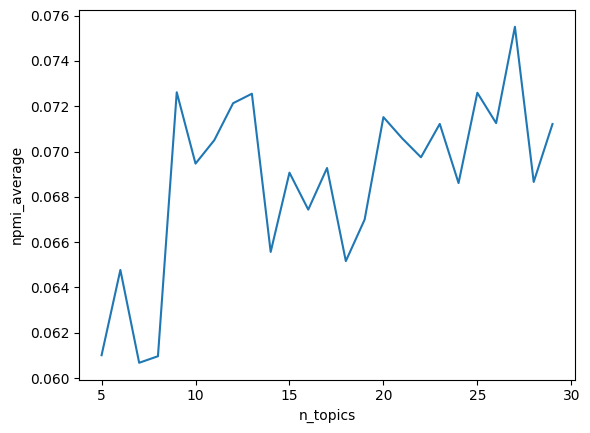

In [29]:
#new and old dataset with downsampling .15
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

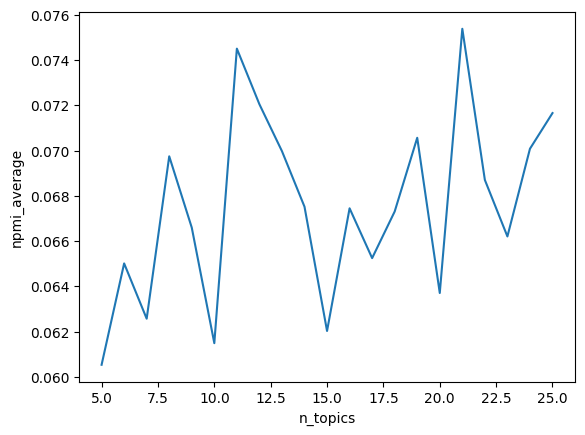

In [15]:
#new and old dataset with downsampling .10
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

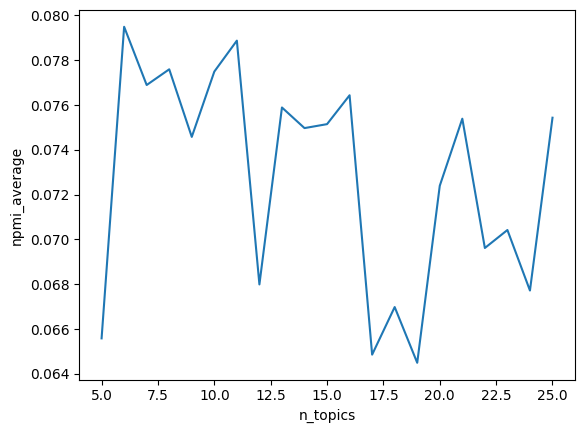

In [98]:
#new and old dataset with downsampling .05
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

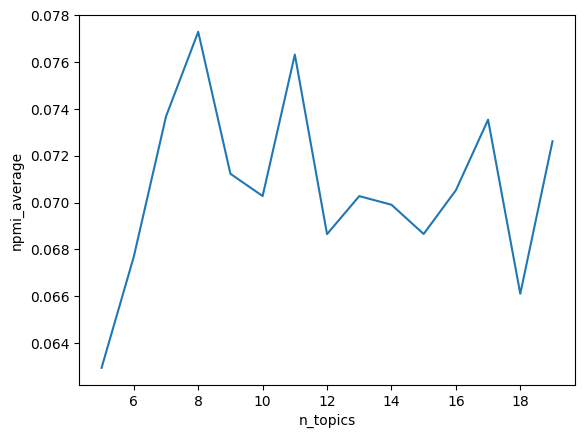

In [16]:
#new and old dataset
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

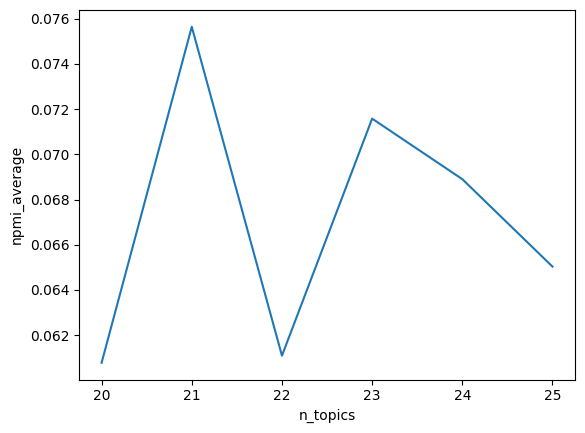

In [18]:
#new dataset
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

# Post-processing

topic distribution and topic selection

for topic selection I used elbow method (selecting top topics till we get to the highest gap)

In [99]:
#topic selection
topics4docs,topics4docs_bin = topic_selection(topic_doc_dist)

#topic distribution addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_dist'.format(i)] = topic_doc_dist[:,i]
#topic selection addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_select'.format(i)] = topics4docs_bin[:,i]

#saving data to csv
text_df.to_csv('document_topic_info.csv')

NameError: name 'topic_doc_dist' is not defined

In [21]:
#storing top terms
topic_df = pd.DataFrame(data=top_terms,columns=['top_terms'])
topic_df.to_csv('topic_terms.csv')

Running Coherence

In [22]:
from lda_mallet import lda_score
import pickle

# import importlib
# importlib.reload(scorer.score_per_topic(None))

#initiate scorer
scorer = lda_score(wiki_path='./data/wiki_sampled_5p.txt',db_path='./data/wiki_full/',npmi_skip_threshold=0.17)

'''
loading wikipedia vocab to 
    1. remove the top terms that are not in the wikipedia
    2. use for gensim.coherence vocab argument in case any pairs are not in the DB
'''
with open('./data/wiki_sampled5p_vocab.obj','rb') as f:
    scorer.wiki_vocab_dict = pickle.load(f)
    
#add all_top_terms (except the ones that are not in the wiki_pedia vocab)
scorer.all_top_terms = [[t for t in top_terms[i].split() if t in scorer.wiki_vocab_dict.token2id.keys()] for i in range(len(top_terms))]
#the output is a dictionary: the key is 0-n_topics and associated with npmi score for top-k topics 
#in which k=5,10,15,20
topic_scores = scorer.score_per_topic(None)
#getting avergae of multiple k for each topic
topic_score_avg = [np.mean([vi for ki,vi in v.items()]) for k,v in topic_scores.items()]

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.17


# soring top terms and top documents

In [23]:
show_top_doc = 10
show_top_terms = 10
file_name = 'top_documents_lda21_new_old_data_new_stopwords_only_english.txt'

#writing the results in a text file
with open(file_name,'w') as tfile:
    for i in range(len(top_terms)):
        #writing top terms
        tfile.write('Topic '+ str(i) + ' : '+'\n'+'top terms: '+', '.join(top_terms[i].split()[:show_top_terms])+'\n')
        #selecting top documents
        top_docs = text_df.sort_values('Topic{0}_dist'.format(i),ascending=False).iloc[0:show_top_doc,:]
        for _,row in top_docs.iterrows():
            tfile.write('Doc ID: {0}, distribution: {1} ; {2} \n'.format(row.id,row['Topic{0}_dist'.format(i)],row['original_text']))
            tfile.write(''.join(['-']*60)+'\n')
        

# Storing to DB

The process is described in the code cell below

**Used the link below to insert and load blob**

https://pynative.com/python-mysql-blob-insert-retrieve-file-image-as-a-blob-in-mysql/

In [15]:
#1. save model id (for LDA save as zip and then save)
'''
2. for each topic
    3. save topic
    4. retreive the saved topic_id and save r_topic_model
    5. for each doc save r_topic_post
'''
###table format
#model: model_id, data, model_type, last_used?
# topic: topic_id, coherence, term1-50, probab1-50
#r_topic_model: topic_id, model_id 
#r_topic_post: topic_id, post_id, proportion

##check the columns of a table
# cursor.execute("show columns from r_topic_post") #execute a command
# myresult = cursor.fetchall() #get all the results 
# myresult

'\n2. for each topic\n    3. save topic\n    4. retreive the saved topic_id and save r_topic_model\n    5. for each doc save r_topic_post\n'

In [69]:
#saving the model first
#model: model_id, data, model_type, last_used?
if model_spec['name'].lower() == 'lda':
    #read binary data of the saved model
    with open('MalletState_ '+model_spec['save_path']+' .gz','rb') as model_file:
        binary_data = model_file.read()
else:
    pass #write codes for other models

#storing the model
cursor.execute(" INSERT INTO model (data, model_type) VALUES (%s,%s)",
                    (binary_data,model_spec['name']))

In [70]:
#load the model with model id to use for next steps
cursor.execute("Select * from model ORDER BY model_id DESC LIMIT 1")
result = cursor.fetchall()
model_id,model_name = result[0][0],result[0][2]

In [71]:
#saving each topic separately alongside relation to model table and post table
for k in range(0,model_spec['K']):#iterating over each topic
    #getting topic top terms
    topic_top_terms = top_terms[k].split()
    #we have to find the index in vocab (ans[0][2]) and then call ans[0][1][k][found_index] to get
    #the probability of each term
    probab = [float(term_probab[k][i]) for w in topic_top_terms for i in range(len(topic_vocab)) if w == topic_vocab[i]]
    #adding coherence score, top terms and their probabilities
    vals = tuple([float(topic_score_avg[k])]) + tuple(topic_top_terms) + tuple(probab)
    #save each topic seperately
    cursor.execute(" INSERT INTO topic(coherence,{0},{1}) VALUES (%s,{2})".format(
                                        ','.join(['term'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['prob'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['%s']*(len(topic_top_terms)*2))),vals)
    
    '''
    retreiving saved topic_id and save an entry for topic_id,model_id in topic_model_r table
    '''
    #load the latest stored topic
    cursor.execute("Select * from topic ORDER BY topic_id DESC LIMIT 1")
    result = cursor.fetchall()
    topic_id = result[0][0]
    #save the topic_id,model_id in r_topic_model table 
    cursor.execute(" INSERT INTO r_topic_model(topic_id,model_id) VALUES (%s,%s)",
                  (topic_id,model_id,))
    
    '''
    saving topic-document proportion for each topic-doc pairs
    '''
    #r_topic_post : topic_id, post_id, proportion
    doc_counter = 0
    for doc_id in list(text_df.id):
        cursor.execute(" INSERT INTO r_topic_post(topic_id,post_id,proportion) VALUES (%s,%s,%s)",
                  (topic_id,doc_id,float(topic_doc_dist[doc_counter,k])))
        doc_counter += 1
        

In [72]:
cnx.commit()

In [21]:
# cursor.execute("delete from r_topic_model")
# cursor.execute("delete from r_topic_post")
# cursor.execute("delete from topic")
# cursor.execute("delete from model")

# cursor.execute("select * from post")
# cursor.execute("SELECT DISTINCT user.* FROM user JOIN post ON user.user_id = post.user_id WHERE post.platform_type_id = %s",('4',))
# cursor.execute("SELECT * FROM post WHERE user_id = %s AND created BETWEEN %s AND %s;",(3,'1/1/2023','1/1/2013',))
# cursor.execute("SELECT r_topic_post.topic_id, AVG(r_topic_post.proportion) as average_proportion FROM r_topic_post JOIN r_topic_model ON r_topic_post.topic_id = r_topic_model.topic_id WHERE r_topic_post.post_id = %s AND r_topic_model.model_id = %s GROUP BY r_topic_post.topic_id;",('1187','2',))
# cursor.execute('select * from model')
cursor.fetchall()

[(11, Decimal('0.005300000')),
 (12, Decimal('0.223030000')),
 (13, Decimal('0.002400000')),
 (14, Decimal('0.007130000')),
 (15, Decimal('0.005350000')),
 (16, Decimal('0.012220000')),
 (17, Decimal('0.006210000')),
 (18, Decimal('0.005680000')),
 (19, Decimal('0.004940000')),
 (20, Decimal('0.727740000'))]

# Post-processing for Author-topic distribution

**if you are reading from DB set the from_db= True**

In [24]:
from_db = False

In [25]:
if not from_db:
    topics = [[i,topic_score_avg[i],'_'.join(top_terms[i].split()[0:3])] \
              for i in range(len(top_terms))]
else:
    #taking last topics 
    cursor.execute("select * from topic")
    topics = [list(i[0:2]) + ['_'.join(i[2:6])] for i in cursor.fetchall()[-7:]] #each topic include topic_id, coherence_score and top three terms

In [26]:
topics

[[0, -6.179527427593602, '#glutenfree_#healthy_#wellness'],
 [1, -16.02898417427859, 'hair_body_wear'],
 [2, -3.362809983182249, 'food_eat_cream'],
 [3, 0.048624416834704705, 'eating_support_alliance'],
 [4, -34.28882313481472, 'therapy_feel_really'],
 [5, -4.3239998447696495, 'sweet_bowl_cheese'],
 [6, -2.1200210709442837, 'year_love_family'],
 [7, 0.027519752843602065, 'body_see_way'],
 [8, 0.08049767772636772, 'life_feel_things'],
 [9, 0.1251985847227629, 'cup_chocolate_butter'],
 [10, 0.12402228932344042, 'oats_butter_milk'],
 [11, -2.3741913951994174, 'eating_body_food'],
 [12, -65.399371705339, 'people_ur_question'],
 [13, -0.6074173284765042, 'plant_work_based'],
 [14, -0.27978828059958166, 'date_protein_code'],
 [15, -1.1296959858319724, 'feel_get_recovery'],
 [16, -53.09603149050897, 'trauma_disorder_self'],
 [17, 0.03322472058025227, 'guys_day_new'],
 [18, -0.9351511268961394, 'day_today_time'],
 [19, -94.13840207913807, 'tree_comment_html'],
 [20, -69.74576109948714, 'questi

In [27]:
#taking post_topics
if from_db:
    cursor.execute("select * from r_topic_post where topic_id between {0} and {1}".format(min(topics)[0],max(topics)[0]))
    res = cursor.fetchall() #topic_id, document_id, topic_dist
    
    doc_dist = {}
    
    for item in res:
        if item[1] not in doc_dist.keys():
            doc_dist[item[1]] = {}
        doc_dist[item[1]][item[0]] = item[2]
else:
    doc_dist = text_df.iloc[:,6:6+len(topics)].values.copy().T#topic_doc_dist.copy().T

In [28]:
#clipping doc_dist and converting to pandas DF as well
from tqdm import tqdm
from similarity import picking_topic

ddist_df = pd.DataFrame(doc_dist).T

ddist_np = ddist_df.values

for i in tqdm(range(ddist_np.shape[0])):
    ddist_np[i] = picking_topic(ddist_np[i].astype('float')) * ddist_np[i].astype('float')

100%|██████████████████████████████████| 13619/13619 [00:00<00:00, 14050.24it/s]


In [29]:
# ddist_df[ddist_df.id==2425]
# ddist_df
# topic_doc_dist.copy().T
# ddist_np[1],ddist_df.iloc[1],text_df.iloc[1]
# ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
# ddist_df['id'] = text_df.index
# ddist_df[ddist_df.id==2425]
# ddist_df
# ddist_df.shape,text_df.shape
# ddist_df.iloc[1232], text_df.iloc[1232]

In [30]:
if from_db:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = ddist_df.index
    ddist_df = ddist_df.merge(text_df[['id','blog']],on='id')
else:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = text_df.index
    ddist_df['blog'] = text_df.blog

In [31]:
ddist_blog = ddist_df.groupby('blog').sum()
ddist_blog.iloc[:,0:-1] = ddist_blog.values[:,0:-1]/np.sum(ddist_blog.values[:,0:-1],axis=0)
ddist_blog

#glutenfree_#healthy_#wellness  hair_body_wear  \
blog                                                                       
Breeelenehan                                    0.000895        0.051403   
alliancefored                                   0.003083        0.019932   
amandavsevilla                                  0.000000        0.077610   
anxiousgayyy                                    0.000000        0.009772   
ariessuntaurusrising                            0.000000        0.038640   
bagelbells                                      0.000000        0.007421   
brittle-bunny                                   0.000000        0.008038   
faithhopeloveandtherapy                         0.001333        0.143756   
fearless-foodie                                 0.000000        0.068102   
finallyrecoveringforgood                        0.000000        0.046217   
fuck-eatingdisorders                            0.000000        0.000000   
healthfulradiance                               0.990320        0.039878   
hellsite-residential                            0.000000        0.050463   
imtrying-butimpissed                            0.000000        0.162648   
intentandotrascender                            0.000000        0.000000   
itsclairexu                                     0.004370        0.023144   
lets-get-better                                 0.000000        0.020544   
matchayogurt                                    0.000000        0.004055   
mirithebrave                                    0.000000        0.070953   
mote-of-dust                                    0.000000        0.012694   
palpitationstation                              0.000000        0.041818   
rec-hovery                                      0.000000        0.000000   
shameofateen                                    0.000000        0.002762   
veganhollyg                                     0.000000        0.100149   

                          food_eat_cream  eating_support_alliance  \
blog                                                                
Breeelenehan                    0.012080                 0.072103   
alliancefored                   0.001255                 0.894513   
amandavsevilla                  0.050479                 0.001263   
anxiousgayyy                    0.004217                 0.000000   
ariessuntaurusrising            0.016374                 0.000362   
bagelbells                      0.000000                 0.000802   
brittle-bunny                   0.006944                 0.000558   
faithhopeloveandtherapy         0.241330                 0.008273   
fearless-foodie                 0.017765                 0.002192   
finallyrecoveringforgood        0.005412                 0.000000   
fuck-eatingdisorders            0.000000                 0.000000   
healthfulradiance               0.038378                 0.000529   
hellsite-residential            0.010016                 0.001212   
imtrying-butimpissed            0.085941                 0.003539   
intentandotrascender            0.001697                 0.000000   
itsclairexu                     0.423262                 0.003394   
lets-get-better                 0.007778                 0.001451   
matchayogurt                    0.005721                 0.000607   
mirithebrave                    0.003638                 0.008068   
mote-of-dust                    0.010072                 0.000000   
palpitationstation              0.001405                 0.000000   
rec-hovery                      0.000000                 0.000000   
shameofateen                    0.005542                 0.000000   
veganhollyg                     0.050694                 0.001135   

                          therapy_feel_really  sweet_bowl_cheese  \
blog                                                               
Breeelenehan                         0.006085           0.005085   
alliancefored                        0.005104     

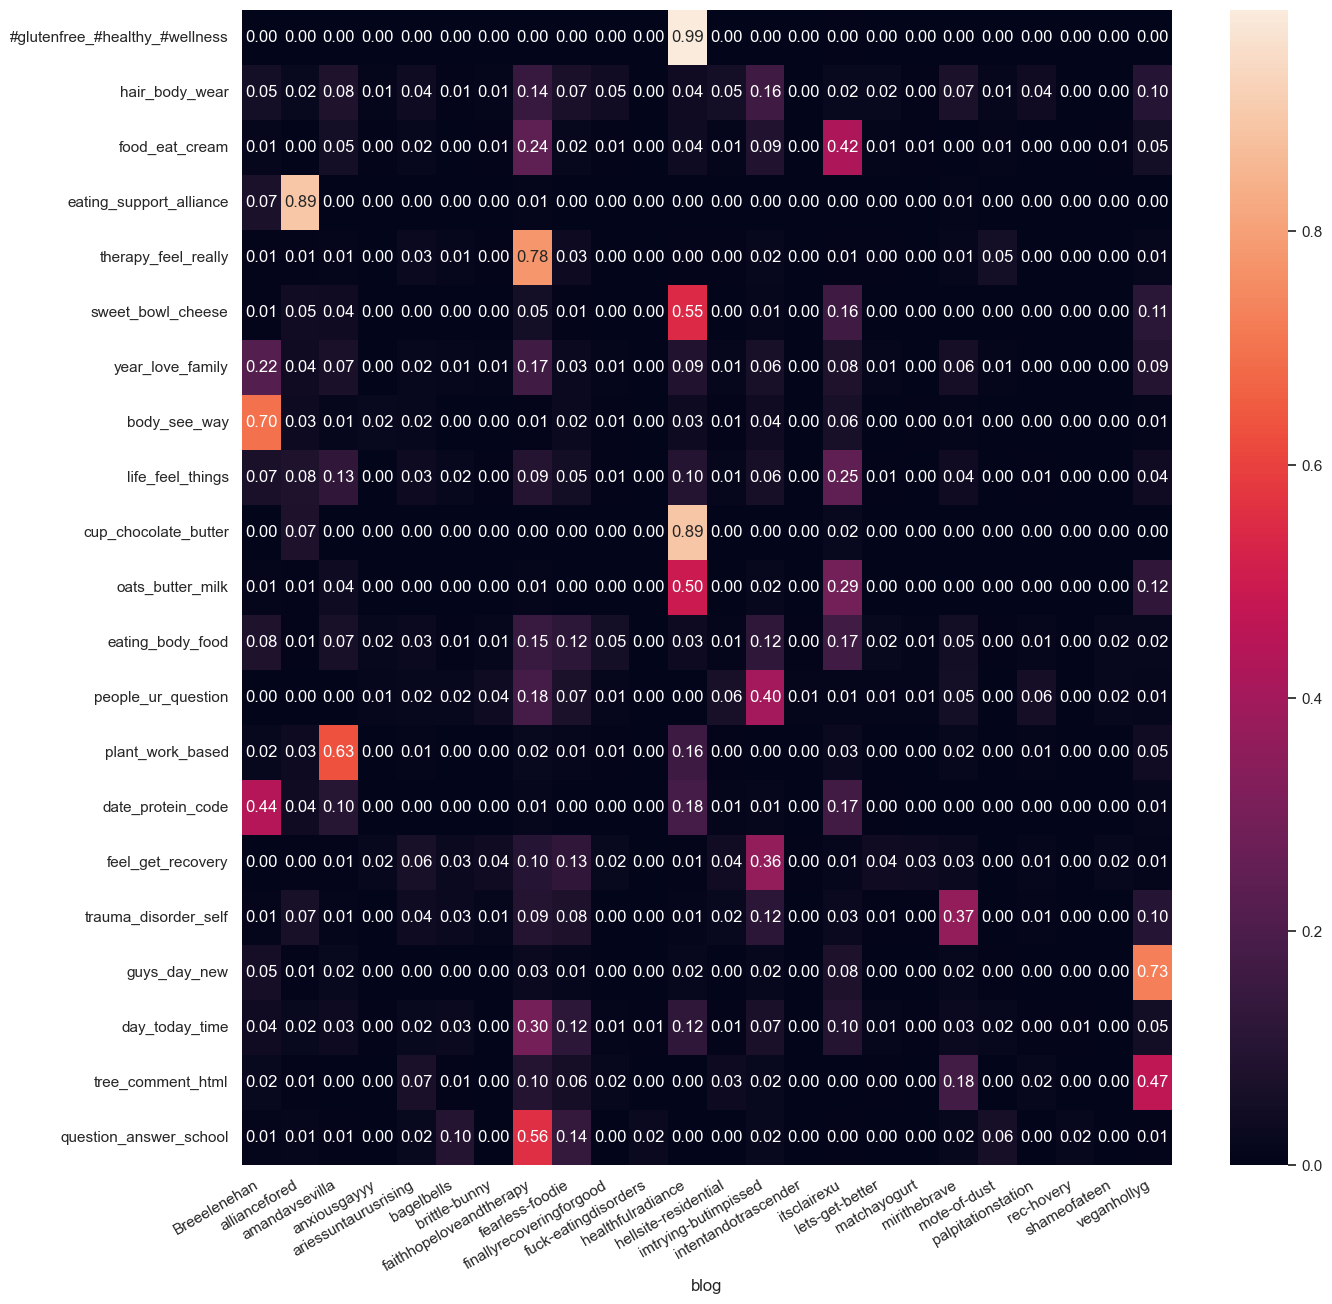

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(ddist_blog.iloc[:,0:-1].astype('float').T,fmt=".2f",annot=True)

plt.xticks(rotation=30,ha='right') 
plt.savefig('./result/edml/new_old_ed_13topics.svg')
# plt.show()

In [33]:
text_df[text_df.id.isin([10491,10596])]

id                                               text  \
6470   10491  kind sandwich ice cream sandwich cathyscle coo...   
6567   10596  shoutout pizza_mikeys creative unique pizzas c...   
12785  10596       thelovelynope deal food report hr harassment   

                                           original_text  \
6470   My kind of sandwich 😎 // ice cream sandwich fr...   
6567   Shoutout to @pizza_mikeys for having the most ...   
12785  thelovelynope:  I-I just don't know how to dea...   

                          date  \
6470       2018-08-28 18:34:30   
6567       2018-06-26 17:12:13   
12785  2020-07-12 12:02:11 GMT   

                                                     url  \
6470            https://www.instagram.com/p/BnCGVyeALTW/   
6567            https://www.instagram.com/p/Bkfu2BKA_OH/   
12785  https://hellsite-residential.tumblr.com/post/6...   

                       blog  Topic0_dist  Topic1_dist  Topic2_dist  \
6470            itsclairexu     0.001684     0.003492     0.898432   
6567            itsclairexu     0.001952     0.004048     0.882260   
12785  hellsite-residential     0.003244     0.006726     0.010792   

       Topic3_dist  ...  Topic11_select  Topic12_select  Topic13_select  \
6470      0.002312  ...             0.0             0.0             0.0   
6567      0.002680  ...             0.0             0.0             0.0   
12785     0.004452  ...             0.0             0.0             0.0   

       Topic14_select  Topic15_select  Topic16_select  Topic17_select  \
6470              0.0             0.0             0.0             0.0   
6567              0.0             0.0             0.0             0.0   
12785             0.0             0.0             0.0             0.0   

       Topic18_select  Topic19_select  Topic20_select  
6470              0.0             0.0             0.0  
6567              0.0             0.0             0.0  
12785             0.0             0.0             1.0  

[3 rows x 48 columns]

In [31]:
text_df[text_df.id.isin([4335,4872,4125,3120,2425])]


id                                               text  \
1102   2425  grew entire life allowed certain foods foods e...   
9403   2425  question feel helpful write fictional story su...   
9968   3120  time stop process journal tuesday therapy sess...   
10807  4125  therapy screenshot avoidant attachment gets ph...   
10987  4335  talking shhh terminating therapy coming end th...   
11408  4872  therapy rupture part sorry therapy session acc...   

                                           original_text  \
1102   I grew up my entire life thinking I'm allowed ...   
9403   Question: I feel like it would be helpful to w...   
9968   I haven't had time to stop and process (journa...   
10807  Therapy .. // screenshot  // avoidant attachme...   
10987  Talking about (shhh🤫) terminating therapy   As...   
11408  Therapy .. // rupture // part   I'm sorry this...   

                          date  \
1102       2022-08-24 10:39:12   
9403   2021-02-19 18:35:15 GMT   
9968   2020-09-10 20:02:30 GMT   
10807  2020-02-06 12:52:03 GMT   
10987  2020-01-08 19:18:49 GMT   
11408  2019-09-14 16:06:09 GMT   

                                                     url  \
1102            https://www.instagram.com/p/Cho522ChBNH/   
9403   https://faithhopeloveandtherapy.tumblr.com/pos...   
9968   https://faithhopeloveandtherapy.tumblr.com/pos...   
10807  https://faithhopeloveandtherapy.tumblr.com/pos...   
10987  https://faithhopeloveandtherapy.tumblr.com/pos...   
11408  https://faithhopeloveandtherapy.tumblr.com/pos...   

                          blog  Topic0_dist  Topic1_dist  Topic2_dist  \
1102              Breeelenehan     0.000914     0.000158     0.057580   
9403   faithhopeloveandtherapy     0.984433     0.000388     0.001292   
9968   faithhopeloveandtherapy     0.986348     0.000340     0.001133   
10807  faithhopeloveandtherapy     0.988824     0.000278     0.000927   
10987  faithhopeloveandtherapy     0.992517     0.000186     0.000621   
11408  faithhopeloveandtherapy     0.992363     0.000190     0.000634   

       Topic3_dist  ...  Topic4_select  Topic5_select  Topic6_select  \
1102      0.001345  ...            0.0            0.0            0.0   
9403      0.003309  ...            0.0            0.0            0.0   
9968      0.002902  ...            0.0            0.0            0.0   
10807     0.002375  ...            0.0            0.0            0.0   
10987     0.001590  ...            0.0            0.0            0.0   
11408     0.001623  ...            0.0            0.0            0.0   

       Topic7_select  Topic8_select  Topic9_select  Topic10_select  \
1102             0.0            1.0            0.0             0.0   
9403             0.0            0.0            0.0             0.0   
9968             0.0            0.0            0.0             0.0   
10807            0.0            0.0            0.0             0.0   
10987            0.0            0.0            0.0             0.0   
11408            0.0            0.0            0.0             0.0   

       Topic11_select  Topic12_select  Topic13_select  
1102              0.0             0.0             0.0  
9403              0.0             0.0             0.0  
9968              0.0             0.0             0.0  
10807             0.0             0.0             0.0  
10987             0.0             0.0             0.0  
11408             0.0             0.0             0.0  

[6 rows x 34 columns]

In [206]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

dataf_rnorm = robjects.DataFrame(ddist_blog.iloc[:,0:-1])
robjects.r(''' 
library(data.table)
topic.title.tall <- melt(setDT(ddist_blog), id.vars = c("title"), variable.name = "topic")
''')

KeyError: <class 'float'>

In [198]:
from plotnine import ggplot, aes, geom_line,geom_tile, scale_fill_gradient
(
ggplot(ddist_blog.iloc[:,0:-1], aes(x='blog')) +
    # geom_tile(aes(fill = value)) + 
    # geom_text(aes(label = round(value, 2))) +
    scale_fill_gradient(low = "white", high = "red")
    # +theme(text = element_text(size=20),axis.text.x = element_text(angle=45, hjust=1))
)

PlotnineError: "Could not evaluate the 'x' mapping: 'blog' (original error: name 'blog' is not defined)"

In [199]:
ddist_blog

eating_support_alliance_us bowl_oats_butter_almond  \
blog                                                                      
Breeelenehan                           0.004505                0.011943   
alliancefored                          0.901694                0.000727   
amandavsevilla                         0.009553                0.019371   
anxiousgayyy                           0.000502                     0.0   
healthfulradiance                      0.009095                0.587512   
imtrying-butimpissed                   0.024045                0.015182   
itsclairexu                            0.036686                0.293368   
veganhollyg                            0.013919                0.071898   

                     life_body_feel_like roasted_#healthy_oil_add  \
blog                                                                
Breeelenehan                    0.032642                 0.002196   
alliancefored                   0.074312                      0.0   
amandavsevilla                  0.158634                 0.015112   
anxiousgayyy                    0.020532                 0.000634   
healthfulradiance                0.09613                 0.699153   
imtrying-butimpissed            0.285263                 0.004865   
itsclairexu                      0.30226                  0.09059   
veganhollyg                     0.030227                 0.187451   

                     body_like_feel_day day_time_one_like  \
blog                                                        
Breeelenehan                   0.805447          0.123988   
alliancefored                  0.035109          0.021241   
amandavsevilla                 0.018207           0.11161   
anxiousgayyy                   0.002199          0.002959   
healthfulradiance              0.027373          0.112608   
imtrying-butimpissed           0.031289          0.040838   
itsclairexu                     0.05645          0.139927   
veganhollyg                    0.023927          0.446829   

                     cup_chocolate_butter_add        id  
blog                                                     
Breeelenehan                         0.006482   1873399  
alliancefored                        0.000715   6127291  
amandavsevilla                       0.005156   6136628  
anxiousgayyy                              0.0    132541  
healthfulradiance                    0.944535  14710522  
imtrying-butimpissed                      0.0   1490061  
itsclairexu                           0.03727  14539093  
veganhollyg                          0.005842  12825333